In [1]:
import random
import sys
import matplotlib.pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps, constant_product_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'R1': 3,
    'R2': 0.7,
    'USD': 1
}

initial_state = GlobalState(
    pools={
        'USD/R1': ConstantProductPoolState(
            tokens={
                'USD': 10000000,
                'R1': 10000000 / price_dict['R1']
            },
            trade_fee=0.01
        ),
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 10000000 / price_dict['R1'],
                'R2': 10000000 / price_dict['R2']
            },
            fee_function = ConstantProductPoolState.custom_slip_fee(1.0)
        )
    },
    agents = {
        # 'Trader': Agent(
        #     holdings={'R1': 100000, 'USD': 100000},
        #     trade_strategy=random_swaps(
        #         pool='USD/R1', 
        #         amount={
        #             'R1': 1000,
        #             'USD': 1000
        #         },
        #         randomize_amount=True
        #     )
        # ),
        'Arbitrageur1': Agent(
            holdings={'USD': 1000000, 'R1': 1000000},
            trade_strategy=constant_product_arbitrage('USD/R1')
        ),
        'Arbitrageur2': Agent(
            holdings={'R1': 100000, 'R2': 1000000},
            trade_strategy=constant_product_arbitrage('R1/R2')
        )
    },
    external_market=price_dict,
    evolve_function=fluctuate_prices(volatility={'R1': 1, 'R2': 0.1}, trend={'R1': -3, 'R2': 0.2})
)

events = run.run(initial_state, time_steps=5000)

events = processing.postprocessing(events, optional_params=['holdings_val', 'pool_val', 'token_count'])
print('finished.')

Starting simulation...
Execution time: 14.492 seconds.
processing {'pool_val', 'holdings_val', 'token_count'}
finished.


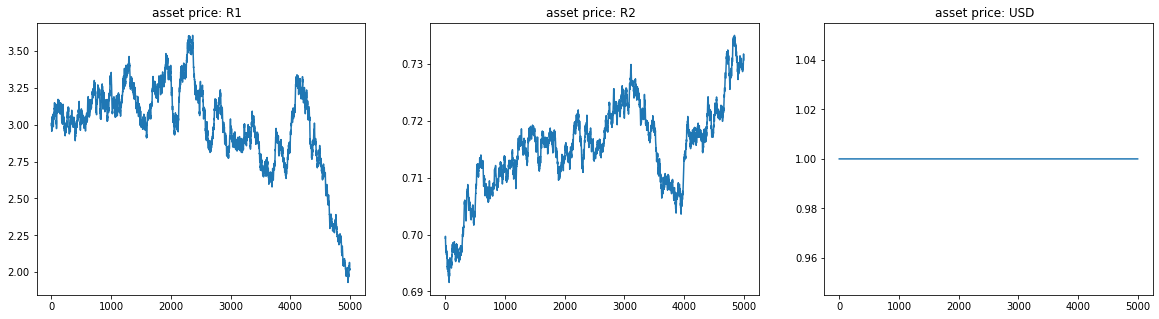

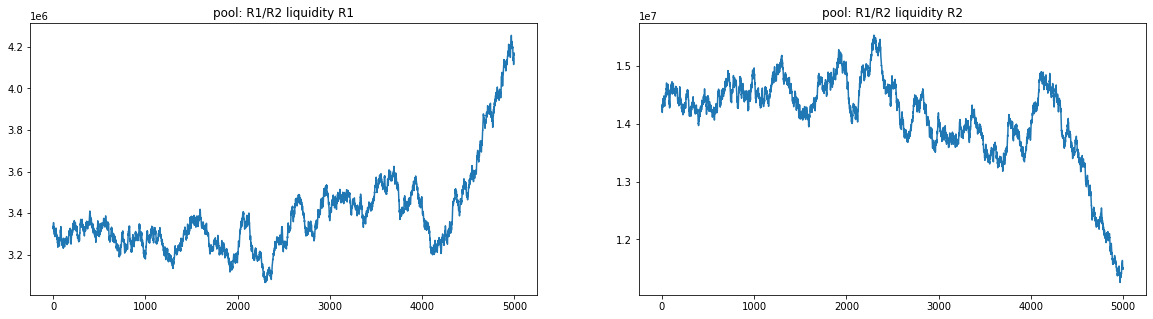

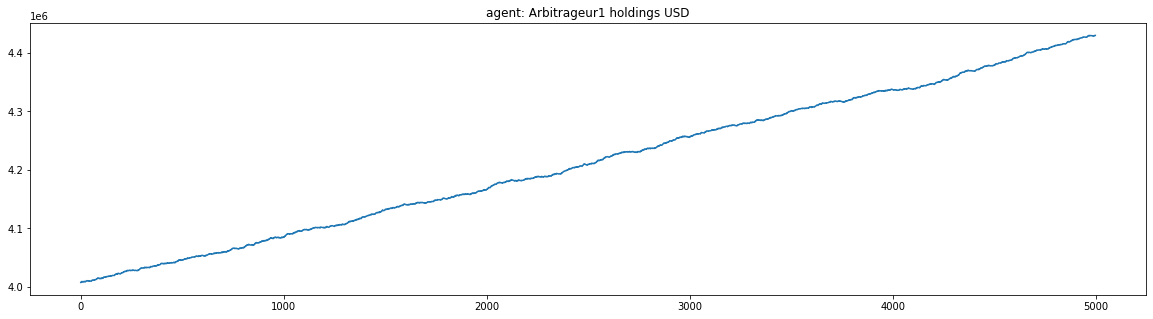

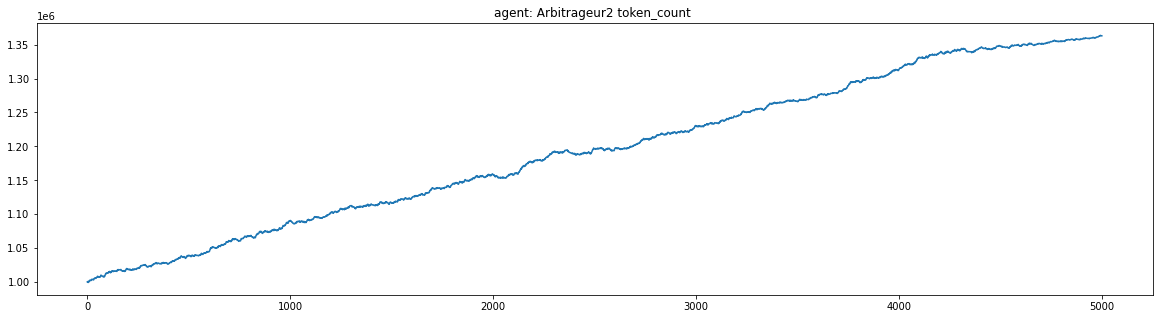

In [2]:
pu.plot(events, asset='all')
pu.plot(events, pool='R1/R2', prop='liquidity')
pu.plot(events, agent='Arbitrageur1', prop='holdings', key='USD')
pu.plot(events, agent='Arbitrageur2', prop='token_count')
# pu.plot(events, agent='Arbitrageur', prop='holdings_val')
# pu.plot(events, pool='USD/R1', prop='pool_val')
# pool_val = pu.get_datastream(events, pool='USD/R1', prop='pool_val')
# holdings_val = pu.get_datastream(events, agent='Arbitrageur', prop='holdings_val')

# y = [holdings_val[i] / pool_val[i] for i in range(len(pool_val))]
# plt.figure(figsize=(20,5))
# ax = plt.subplot(111, title='Arbitrageur performance vs market')
# ax.plot(range(len(events)), y, label='Profit')

# y = [sum([hold for hold in event['state'].agents['Arbitrageur'].holdings.values()]) for event in events]
# plt.figure(figsize=(20,5))
# ax = plt.subplot(111, title='Arbitrageur total holdings')
# ax.plot(range(len(events)), y, label='Profit')

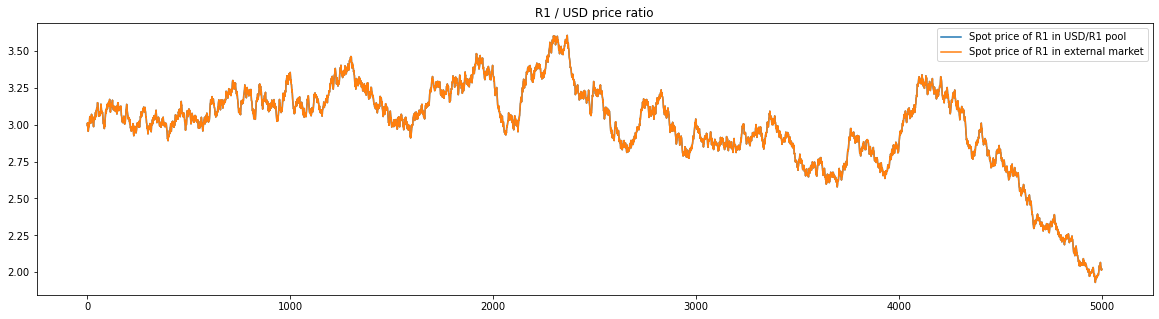

<Figure size 1440x360 with 0 Axes>

In [3]:
usd_pool = pu.get_datastream(events, pool='USD/R1', prop='liquidity', key='USD')
R1_pool = pu.get_datastream(events, pool='USD/R1', prop='liquidity', key='R1')
R1_ratio = [usd_pool[i] / R1_pool[i] for i in range(len(events))]
plt.figure(figsize=(20,5))
ax = plt.subplot(111, title='R1 / USD price ratio')
ax.plot(range(len(events)), R1_ratio, label='Spot price of R1 in USD/R1 pool')
pu.plot(events, asset='R1', subplot=ax, label='Spot price of R1 in external market')
ax.legend()

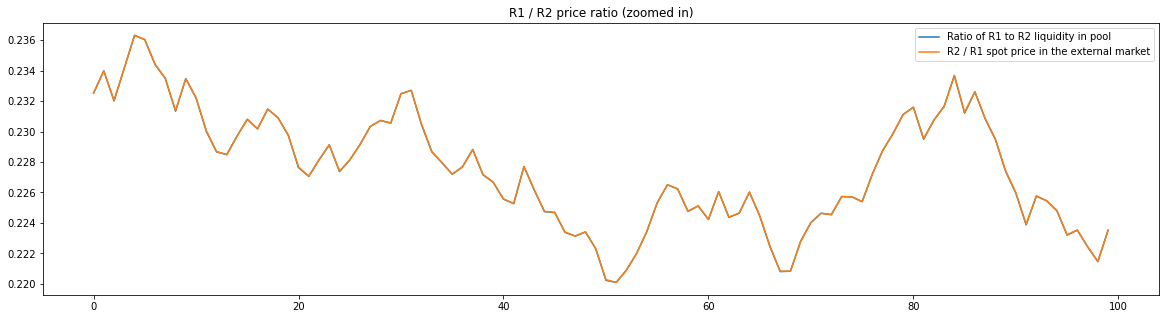

In [4]:
R2_pool = pu.get_datastream(events, pool='R1/R2', prop='liquidity', key='R2')
R1_pool = pu.get_datastream(events, pool='R1/R2', prop='liquidity', key='R1')
R1_price = pu.get_datastream(events, asset='R1')
R2_price = pu.get_datastream(events, asset='R2')
pool_ratio = [R1_pool[i] / R2_pool[i] for i in range(len(events))]
price_ratio = [R2_price[i] / R1_price[i] for i in range(len(events))]
plt.figure(figsize=(20,5))
ax = plt.subplot(111, title='R1 / R2 price ratio (zoomed in)')
ax.plot(range(100), pool_ratio[:100], label='Ratio of R1 to R2 liquidity in pool')
ax.plot(range(100), price_ratio[:100], label='R2 / R1 spot price in the external market')
ax.legend() 

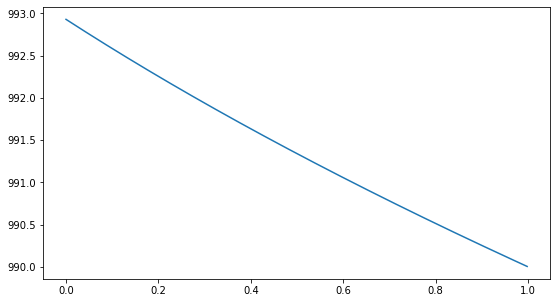

In [5]:
x = 1000
y = 1000

import math
import pdb

def price_after_trade(buy_amount, fee):
    sell_amount = -(x - (x * y) / (y - buy_amount) * (1 + fee))
    return (y - buy_amount) / (x + sell_amount)

def find_b(target_price, fee):
    y2 = math.sqrt(x * y * target_price)
    b = y - y2    
    previous_change = 1
    p = price_after_trade(b, fee)
    previous_price = p
    diff = p / target_price
    
    while abs(1 - diff) > 0.000000001:
        progress = (previous_price - p) / (previous_price - target_price) or 2
        old_b = b
        b -= previous_change * (1 - 1 / progress)
        previous_price = p
        previous_change = b - old_b
        p = price_after_trade(b, fee)
        diff = p / target_price
        
    return b

target_price = 0.00005

f_range = [i / 500 for i in range(500)]
b_range = [find_b(target_price, f) for f in f_range]
plt.figure(figsize=(20, 5))
ax = plt.subplot(121)
ax.plot(f_range, b_range)